In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
import numpy as np
import pickle
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from stanfordcorenlp import StanfordCoreNLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
MAX_PHRASE_LEN = 6
VECTOR_SIZE = 200
WINDOW_SIZE = 5
NUM_LAYERS = 5

MIN_FREQUENCY = 5

SHOULD_EXTRACT_NOUN_PHRASES = False
SHOULD_GENERATE_UNDERSCORED_CORPUS = False
SHOULD_TRAIN_WORD2VEC_MODEL = False

EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
with open('data/arxiv_abstracts_10000.txt', 'r') as f:
    arxiv_abstracts = f.read().split('\n')[:-1]
    arxiv_abstracts_raw = '\n'.join(arxiv_abstracts)
    f.close()
print(f'Loaded {len(arxiv_abstracts)} arxiv abstracts.')

Loaded 10000 arxiv abstracts.


In [5]:
negative_samples = pickle.load(open('data/negative_samples.pkl', 'rb'))
print(f'Loaded {len(negative_samples)} negative samples.')

Loaded 1900 negative samples.


In [6]:
positive_samples = pickle.load(open('data/positive_samples.pkl', 'rb'))
print(f'Loaded {len(positive_samples)} positive samples.')

Loaded 1900 positive samples.


In [7]:
def extract_phrase(tree_str, label):
    phrases = []
    trees = Tree.fromstring(tree_str)
    for tree in trees:
        for subtree in tree.subtrees():
            if subtree.label() == label:
                t = subtree
                t = ' '.join(t.leaves())
                phrases.append(t)
    return phrases

In [8]:
if SHOULD_EXTRACT_NOUN_PHRASES:
    nlp = StanfordCoreNLP('data/stanford-corenlp-4.1.0')
    noun_phrases = []
    for i, abstract in enumerate(arxiv_abstracts):
        if (i + 1) % 10 == 0:
            print(f'Extracting noun phrases from abstract {i + 1} of {len(arxiv_abstracts)}')
            pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
        try:
            tree_str = nlp.parse(abstract)
            noun_phrases.extend(extract_phrase(tree_str, 'NP'))
        except Exception:
            pass
    noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]
    pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
noun_phrases = pickle.load(open('data/noun_phrases.pkl', 'rb'))
noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]

In [9]:
def find_phrase_in_corpus(corpus, phrase):
    s_idx = corpus.find(phrase)
    e_idx = s_idx + len(phrase)
    if s_idx != -1 and \
       (s_idx == 0 or corpus[s_idx - 1] in (string.punctuation + ' ')) and \
       (e_idx == len(corpus) or corpus[e_idx] in (string.punctuation + ' ')):
        return (s_idx, e_idx)
    return (-1, -1)

In [10]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    corpus = arxiv_abstracts_raw[:]

In [11]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, positive_sample in enumerate(positive_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing positive_sample {i + 1} of {len(positive_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, positive_sample) != (-1, -1) and find_phrase_in_corpus(corpus, positive_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, positive_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + positive_sample.replace(' ', '_') + corpus[e_idx:]

In [12]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, negative_sample in enumerate(negative_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing negative_sample {i + 1} of {len(negative_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, negative_sample) != (-1, -1) and find_phrase_in_corpus(corpus, negative_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, negative_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + negative_sample.replace(' ', '_') + corpus[e_idx:]

In [13]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, noun_phrase in enumerate(noun_phrases):
        if (i + 1) % 100 == 0:
            print(f'Replacing noun_phrase {i + 1} of {len(noun_phrases)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, noun_phrase) != (-1, -1) and find_phrase_in_corpus(corpus, noun_phrase)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, noun_phrase)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + noun_phrase.replace(' ', '_') + corpus[e_idx:]

In [14]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    pickle.dump(corpus, open('data/underscored_corpus.pkl', 'wb'))

In [15]:
underscored_corpus = pickle.load(open('data/underscored_corpus.pkl', 'rb'))

In [16]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    underscored_corpus_data = []
    for i in sent_tokenize(underscored_corpus):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        underscored_corpus_data.append(temp)

In [17]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    word2vec_model = Word2Vec(underscored_corpus_data, min_count=1, window=WINDOW_SIZE, size=VECTOR_SIZE)
    word2vec_model.save(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [18]:
word2vec_model = Word2Vec.load(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [19]:
tokens = [token for token in list(word2vec_model.wv.vocab.keys())]
embeddings = {token: word2vec_model.wv[token] for token in tokens}

In [20]:
positive_samples = [ps for ps in positive_samples if ps.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ps.replace(' ', '_')].count >= MIN_FREQUENCY]
negative_samples = [ns for ns in negative_samples if ns.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ns.replace(' ', '_')].count >= MIN_FREQUENCY]
noun_phrases = [np for np in noun_phrases if np.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[np.replace(' ', '_')].count >= MIN_FREQUENCY]

In [21]:
X = []
y = []
for phrase in positive_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(1)
for phrase in negative_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(0)

In [22]:
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(VECTOR_SIZE, 128)
        
        self.layers = []
        for _ in range(NUM_LAYERS - 1):
            self.layers.append(nn.Linear(128, 128))
        
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        
        for layer in self.layers:
            x = self.relu(layer(x))

        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=200, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train, dtype=np.float64)), 
                          torch.FloatTensor(y_train))

In [28]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test, dtype=np.float64)))

In [29]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    if e % 10 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.55782 | Acc: 76.158
Epoch 020: | Loss: 0.45829 | Acc: 79.263
Epoch 030: | Loss: 0.42237 | Acc: 81.158
Epoch 040: | Loss: 0.39776 | Acc: 82.421
Epoch 050: | Loss: 0.38078 | Acc: 83.211
Epoch 060: | Loss: 0.36429 | Acc: 83.474
Epoch 070: | Loss: 0.34761 | Acc: 84.579
Epoch 080: | Loss: 0.33374 | Acc: 85.737
Epoch 090: | Loss: 0.32415 | Acc: 85.947
Epoch 100: | Loss: 0.31406 | Acc: 86.105
Epoch 110: | Loss: 0.30654 | Acc: 86.526
Epoch 120: | Loss: 0.29896 | Acc: 87.211
Epoch 130: | Loss: 0.28493 | Acc: 87.895
Epoch 140: | Loss: 0.27787 | Acc: 88.053
Epoch 150: | Loss: 0.27384 | Acc: 87.947
Epoch 160: | Loss: 0.26638 | Acc: 88.632
Epoch 170: | Loss: 0.25915 | Acc: 89.000
Epoch 180: | Loss: 0.25309 | Acc: 89.632
Epoch 190: | Loss: 0.24879 | Acc: 90.526
Epoch 200: | Loss: 0.24275 | Acc: 89.895


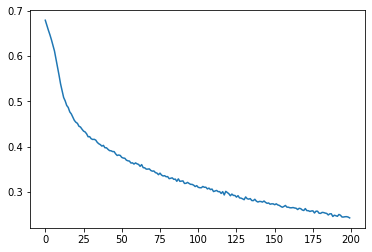

In [32]:
plt.plot(epoch_losses)

In [33]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [34]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[ 75  38]
 [ 14 177]]
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       113
           1       0.82      0.93      0.87       191

    accuracy                           0.83       304
   macro avg       0.83      0.80      0.81       304
weighted avg       0.83      0.83      0.82       304



In [35]:
test_samples = random.sample(noun_phrases, 1000)
X_samples = []
for sample in test_samples:
    X_samples.append(embeddings[sample.replace(' ', '_')])
sample_data = TestDataset(torch.FloatTensor(np.array(X_samples, dtype=np.float64)))
sample_loader = DataLoader(dataset=sample_data, batch_size=1)

extracted = []
not_extracted = []
model.eval()
with torch.no_grad():
    for i, X_batch in enumerate(sample_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        if y_pred_tag.cpu().numpy()[0][0] == 1:
            extracted.append(test_samples[i])
        else:
            not_extracted.append(test_samples[i])

In [36]:
extracted

['character level',
 'each pixel',
 'data sparsity',
 'eight',
 'optimizations',
 'future observations',
 'correction',
 'the prediction',
 'natural languages',
 'activation functions',
 'chain monte carlo mcmc',
 'bioinformatics',
 'real world',
 'the convergence',
 'maximum likelihood',
 'satellites',
 'a phenomenon',
 'statistical learning',
 'split',
 'multiple levels',
 'the last decade',
 'a posteriori map inference',
 'great importance',
 'svms',
 'invariant representations',
 'network',
 'bandits',
 'data centers',
 'low dimensional subspaces',
 'an empirical study',
 'neural networks based',
 'curiosity',
 'embedded devices',
 'a promising alternative',
 'the resulting models',
 'simulated annealing',
 'volumes',
 'distributed',
 'blind source separation',
 'carla',
 'manner',
 'limits',
 'a series',
 'architecture',
 'xx',
 'real world problems',
 'parallel corpora',
 'probability',
 'neighborhood',
 'the dictionary',
 'an adversary',
 'diagnosis',
 'matrix',
 'option',
 'dis

In [37]:
not_extracted

['snns',
 'papers',
 'whole',
 'new algorithms',
 'language models',
 'monolingual',
 'inter',
 'training instances',
 'modeling',
 'perturbations',
 'the missing',
 'findings',
 'multimodal',
 'players',
 'other words',
 'advances',
 'deep architectures',
 'cues',
 'limitations',
 'cross',
 'directions',
 'resnets',
 'the real world',
 'the hidden',
 'neurons',
 'machines',
 'sgan',
 'attention weights',
 'semi',
 'explanations',
 'competitive results',
 'large amount',
 'objective',
 'ssl',
 'exact',
 'primal',
 'researchers',
 'better',
 'instances',
 'changes',
 'modalities',
 'operations',
 'neural network models',
 'tuning',
 'natural',
 'chatbot',
 'relations',
 'under',
 'gaussian',
 'distributions',
 'component',
 'machine learning tasks',
 'rnn',
 'a wealth',
 'trees',
 'variational',
 'the features',
 'benchmark datasets',
 'causal models',
 'a large scale',
 'connections',
 'reinforcement learning methods',
 'explored',
 'brain',
 'synonyms',
 'aspects',
 'behaviors',
 'use